In [1]:
import casadi as ca
import numpy as np
from mpc_model import Model
from mpc_simulation import  Simulator
from mpc_solver import MPC
from mpc_plot import Plot
import matplotlib.pyplot as plt

## Furuta Pendulum

$$
\begin{array}{r}
\left(\alpha+\beta \sin ^{2} \theta\right) \ddot{\phi}+\gamma \cos \theta \ddot{\theta}+2 \beta \cos \theta \sin \theta \dot{\phi} \dot{\theta}-\gamma \sin \theta \dot{\theta}^{2}=\tau_{\phi} \\
\gamma \cos \theta \ddot{\phi}+\beta \ddot{\theta}-\beta \cos \theta \sin \theta \dot{\phi}^{2}-\delta \sin \theta=\tau_{\theta}
\end{array}
$$

### State space model
$$x_1 = \phi, x_2 = \dot{\phi} , x_3 = \theta, x_4 = \dot{\theta}, u_1 = \tau_{\phi}, u_2 = \tau_{\theta}$$

$$
\begin{aligned}
\frac{dx_1}{dt} &= x_2\\
\frac{dx_2}{dt}  &=\frac{1}{\alpha \beta-\gamma^{2}+\left(\beta^{2}+\gamma^{2}\right) \sin ^{2} x_3}\left\{\beta \gamma\left(\sin ^{2} x_3-1\right) \sin x_3 x_2^{2}-2 \beta^{2} \cos x_3 \sin x_3 x_2 x_4+\beta \gamma \sin x_3 x_4^{2}-\gamma \delta \cos x_3 \sin x_3+\beta u_1-\gamma \cos x_3 u_2\right\} \\
\frac{dx_3}{d t} &=x_4 \\
\frac{dx_4}{d t} &=\frac{1}{\alpha \beta-\gamma^{2}+\left(\beta^{2}+\gamma^{2}\right) \sin ^{2} x_3}\left\{\beta\left(\alpha+\beta \sin ^{2} x_3\right) \cos x_3 \sin x_3 x_2^{2}+2 \beta \gamma\left(1-\sin ^{2} x_3\right) \sin x_3 x_2 x_4-\gamma^{2} \cos x_3 \sin x_3 x_4^{2}+\delta\left(\alpha+\beta \sin ^{2} x_3\right) \sin x_3-\gamma \cos x_3 u_1+\left(\alpha+\beta \sin ^{2} x_3\right) u_2\right\}
\end{aligned}
$$


In [2]:
def furuta_ode(t, x, u, p):
    """
    Furuta Pendulum
    """
    # Parameter configuration
    alpha = p[0]
    beta =  p[1]
    delta = p[2]
    gamma = p[3]

    dx1_dt = x[1]
    dx2_dt = 1 / (alpha * beta - gamma ** 2 + (beta ** 2 + gamma ** 2) * ca.sin(x[2]) ** 2) * (
                beta * gamma * (ca.sin(x[2] ** 2 - 1)) * ca.sin(x[2]) * x[1] ** 2 - 2 * beta ** 2 * ca.cos(
            x[2]) * ca.sin(x[2]) * x[1] * x[3] + beta * gamma * ca.sin(x[2]) * x[3] ** 2 - gamma * delta * ca.cos(
            x[2]) * ca.sin(x[2]) + beta * u[0] - gamma * ca.cos(x[2]) * u[1])
    dx3_dt = x[3]
    dx4_dt = 1 / (alpha * beta - gamma ** 2 + (beta ** 2 + gamma ** 2) * ca.sin(x[2]) ** 2) * (
                beta * (alpha + beta * ca.sin(x[2]) ** 2) * ca.cos(x[2]) * ca.sin(x[2]) * x[
            1] ** 2 + 2 * beta * gamma * (1 - ca.sin(x[2]) ** 2) * ca.sin(x[2]) * x[1] * x[3] - gamma ** 2 * ca.cos(
            x[2]) * ca.sin(x[2]) * x[3] ** 2 + delta * (alpha + beta * ca.sin(x[2]) ** 2) * ca.sin(
            x[2]) - gamma * ca.cos(x[2]) * u[0] + (alpha + beta * ca.sin(x[2]) ** 2) * u[1])

    rhs = [dx1_dt,
           dx2_dt,
           dx3_dt,
           dx4_dt
           ]
    return ca.vertcat(*rhs)

In [3]:
def set_constraint(N_pred):
    # set constraint
    lbx = [0, 0, -ca.pi, 0]
    ubx = [0, 0, -ca.pi, 0]
    lbx += [-ca.pi, -ca.inf, -ca.pi, -ca.inf, -ca.inf, -ca.inf] * N_pred
    ubx += [ca.pi, ca.inf, 2 * ca.pi, ca.inf, ca.inf, ca.inf] * N_pred

    x0 = [0, 0, -ca.pi, 0]
    x0 += [0, 0, 0, 0, 0, 0] * N_pred

    lbg = [0, 0, 0, 0] * N_pred
    ubg = [0, 0, 0, 0] * N_pred

    p = [0, 0, 0, 0, 0, 0, 0]

    return lbx, ubx, lbg, ubg, p, x0

In [4]:
Nt = 1
Nx = 4
Nu = 2
Np = 0
Nz = 0

delta_t = 0.01
N_pred = 50
N_sim = 100

t_SX = ca.SX.sym("t_SX", Nt)
x_SX = ca.SX.sym("x_SX", Nx)
u_SX = ca.SX.sym("u_SX", Nu)
p_SX = ca.SX.sym("p_SX", Np)
z_SX = ca.SX.sym("z_SX", Nz)

alpha = 0.0033472
beta =  0.0038852
delta = 0.097625
gamma = 0.0024879

para = [alpha,beta,delta,gamma]

furuta_ode(t_SX, x_SX, u_SX, para)
lbx, ubx, lbg, ubg, p, x0 = set_constraint(N_pred)


xr_SX = ca.SX.sym("xr_SX", Nx)
ur_SX = ca.SX.sym("ur_SX", Nu)
Q = np.diag([10, 1, 100, 1])
R = np.diag([1, 1])
Q_f = np.diag([0, 0, 0, 0])
stage_cost = (x_SX - xr_SX).T @ Q @ (x_SX - xr_SX) + (u_SX - ur_SX).T @ R @ (u_SX - ur_SX)    #  Lagrange term
terminal_cost = (x_SX - xr_SX).T @ Q_f @ (x_SX - xr_SX)    #  Mayer term
stage_cost_func = ca.Function("stage_cost_func",[x_SX, xr_SX, u_SX, ur_SX], [stage_cost])
terminal_cost_func = ca.Function("terminal_cost_func",[x_SX, xr_SX], [terminal_cost])

model = Model(t_SX, x_SX, u_SX, z_SX, p_SX, delta_t, para=para, ode=furuta_ode, alg=None, opt=None,
              stage_cost_func=stage_cost_func, terminal_cost_func=terminal_cost_func)

mpc_solver = MPC(model, N_pred)
mpc_simulator = Simulator(model, mpc_solver, N_sim, lbx, ubx, lbg, ubg, p, x0)

(304, 1)

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      100
                     variables with only upper bounds:        0
Total number of equality constraints.................:      200
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....:


Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   2.2529478872616693e+01    2.2529478872616693e+01
Dual infeasibility......:   2.8865798640254070e-14    2.8865798640254070e-14
Constraint violation....:   6.3948846218409017e-14    6.3948846218409017e-14
Complementarity.........:   2.5067907014880508e-09    2.5067907014880508e-09
Overall NLP error.......:   2.5067907014880508e-09    2.5067907014880508e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.005
Total CPU secs in NLP function evaluations     


Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   3.7349596828767413e+00    3.7349596828767413e+00
Dual infeasibility......:   6.2172489379008766e-15    6.2172489379008766e-15
Constraint violation....:   9.0594198809412774e-14    9.0594198809412774e-14
Complementarity.........:   2.5068938356119942e-09    2.5068938356119942e-09
Overall NLP error.......:   2.5068938356119942e-09    2.5068938356119942e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.005
Total CPU secs in NLP function evaluations     


Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   6.2289461333548080e-01    6.2289461333548080e-01
Dual infeasibility......:   2.8310687127941492e-15    2.8310687127941492e-15
Constraint violation....:   5.9952043329758453e-14    5.9952043329758453e-14
Complementarity.........:   2.5067294119938690e-09    2.5067294119938690e-09
Overall NLP error.......:   2.5067294119938690e-09    2.5067294119938690e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.005
Total CPU secs in NLP function evaluations     


                                   (scaled)                 (unscaled)
Objective...............:   1.0633600015500383e-01    1.0633600015500383e-01
Dual infeasibility......:   1.1657341758564144e-15    1.1657341758564144e-15
Constraint violation....:   2.6756374893466273e-14    2.6756374893466273e-14
Complementarity.........:   2.5066873019966346e-09    2.5066873019966346e-09
Overall NLP error.......:   2.5066873019966346e-09    2.5066873019966346e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.006
Total CPU secs in NLP function evaluations           =      0.018

EXIT: Opt


Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   2.3518075339480221e-02    2.3518075339480221e-02
Dual infeasibility......:   5.5164206536062466e-16    5.5164206536062466e-16
Constraint violation....:   1.2267964422107980e-14    1.2267964422107980e-14
Complementarity.........:   2.5066800603543002e-09    2.5066800603543002e-09
Overall NLP error.......:   2.5066800603543002e-09    2.5066800603543002e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.005
Total CPU secs in NLP function evaluations     


Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   5.1945736590713826e-03    5.1945736590713826e-03
Dual infeasibility......:   2.3418766925686896e-16    2.3418766925686896e-16
Constraint violation....:   4.9960036108132044e-15    4.9960036108132044e-15
Complementarity.........:   2.5066794081048613e-09    2.5066794081048613e-09
Overall NLP error.......:   2.5066794081048613e-09    2.5066794081048613e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.005
Total CPU secs in NLP function evaluations     


Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   1.4767478911669055e-03    1.4767478911669055e-03
Dual infeasibility......:   8.5001450322863548e-17    8.5001450322863548e-17
Constraint violation....:   1.8249290967276011e-15    1.8249290967276011e-15
Complementarity.........:   2.5066806325771147e-09    2.5066806325771147e-09
Overall NLP error.......:   2.5066806325771147e-09    2.5066806325771147e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.005
Total CPU secs in NLP function evaluations     


                                   (scaled)                 (unscaled)
Objective...............:   6.8227816235708462e-04    6.8227816235708462e-04
Dual infeasibility......:   3.4260788650541940e-17    3.4260788650541940e-17
Constraint violation....:   7.2511441295830537e-16    7.2511441295830537e-16
Complementarity.........:   2.5066819224032361e-09    2.5066819224032361e-09
Overall NLP error.......:   2.5066819224032361e-09    2.5066819224032361e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.005
Total CPU secs in NLP function evaluations           =      0.020

EXIT: Opt


Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   3.7337615478558504e-04    3.7337615478558504e-04
Dual infeasibility......:   1.3660947373317356e-17    1.3660947373317356e-17
Constraint violation....:   2.8449465006019636e-16    2.8449465006019636e-16
Complementarity.........:   2.5066830588914335e-09    2.5066830588914335e-09
Overall NLP error.......:   2.5066830588914335e-09    2.5066830588914335e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.005
Total CPU secs in NLP function evaluations     

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      100
                     variables with only upper bounds:        0
Total number of equality constraints.................:      200
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   2.2987511872326561e-04    2.2987511872326561e-04
Dual infeasibility......:   5.9980520577445143e-18    5.9980520577445143e-18
Constraint violation....:   1.1709383462843448e-16    1.1709383462843448e-16
Complementarity.........:   2.5066838957268407e-09    2.5066838957268407e-09
Overall NLP error.......:   2.5066838957268407e-09    2.5066838957268407e-09




Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   1.4371616389703706e-04    1.4371616389703706e-04
Dual infeasibility......:   5.2139113068238457e-18    5.2139113068238457e-18
Constraint violation....:   4.4669129506402783e-17    4.4669129506402783e-17
Complementarity.........:   2.5066845786552157e-09    2.5066845786552157e-09
Overall NLP error.......:   2.5066845786552157e-09    2.5066845786552157e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.005
Total CPU secs in NLP function evaluations     

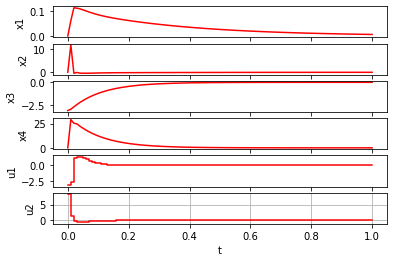

In [5]:
mpc_plot = Plot(mpc_simulator)
mpc_plot.plot_multi()

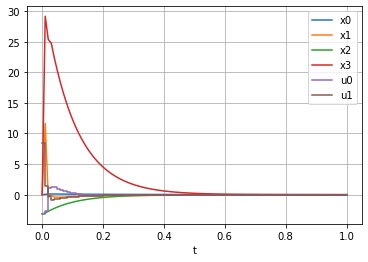

In [6]:
mpc_plot.plot_single()